# Assignment 2 - Bank Marketing

Link to the data: https://archive.ics.uci.edu/dataset/222/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
2) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
3) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
4) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y) by this research question:

'To what extent does the inclusion of socio-economic variables improve the accuracy of predicting client subscription to term deposits when compared to only using demographic variables?'


In [67]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import skfuzzy as fuzz
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [68]:
df_bank = pd.read_csv('Ass2Data\\bank\\bank.csv', delimiter=';')
df_bank_full = pd.read_csv('Ass2Data\\bank\\bank-full.csv', delimiter=';')
df_bank_additional = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional.csv', delimiter=';')
df_bank_additional_full = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional-full.csv', delimiter=';')
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Comparison between the 4 datasets
- df_bank: 4521 rows, 17 columns
- df_bank_full: 45211 rows, 17 columns

df_bank and df_bank_full have the same columns

- df_bank_additional: 4119 rows, 21 columns.
- df_bank_additional_full: 41188 rows, 21 columns.

Columns that are in the 'additional' datasets but not in the other 2: emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Our research question, as written in the report, is: **Which client demographics (age, job, marital status, etc.) have the most influence on whether or not a client subscribes to a term deposit?**

Therefore, we will first filter out the columns that are not related to the client demographics. We will then perform exploratory data analysis to understand the data better. Since the 'additional' datasets do not contain demographic variables, we will take a subset of the regular bank_full dataset.

In [69]:
demographic_variables = ['age', 'job', 'marital', 'education', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
df_demo = df_bank_additional_full[demographic_variables]

Demographic variables: \
`age` (numeric) \
`job` : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown") \
`marital` : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed) \
`education` (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

Social and economic context variables: \
`emp.var.rate`: employment variation rate - quarterly indicator (numeric) \
`cons.price.idx`: consumer price index - monthly indicator (numeric)     
`cons.conf.idx`: consumer confidence index - monthly indicator (numeric)
`euribor3m`: euribor 3 month rate - daily indicator (numeric) \
`nr.employed`: number of employees - quarterly indicator (numeric)   

# Advanced Exploratory Data Analysis 
Apply techniques from clustering and association rule mining domains.
- Data Cleaning: Outlier detection, summarizing dataset, descriptive stats, visualizations. Distribution of key variables
- AEDA: Scaling, normalization, one hot encoding, pair plots, correlation heatmaps
- Univariate and multivariate
- 2 clustering algorithms and evaluate them
- 2D plots, 3D plots
- association rules mining, evaluate them

## Data cleaning - iris
### Difference between dataframes

In [70]:
# Define difference in columns
columns_diff = set(df_bank_additional_full.columns) - set(df_bank_full.columns)
print(columns_diff)

{'euribor3m', 'day_of_week', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed'}


Conclusion:

`df_bank_additional_full` contains the day of the week, and has the social and economic context attributes.

These attributes represent:

`emp.var.rate`: employment variation rate - quarterly indicator (numeric) \
`cons.price.idx`: consumer price index - monthly indicator (numeric)     
`cons.conf.idx`: consumer confidence index - monthly indicator (numeric)
`euribor3m`: euribor 3 month rate - daily indicator (numeric) \
`nr.employed`: number of employees - quarterly indicator (numeric)

### Null values

Next, we will check for potential null values in our dataset. As mentioned in the data description: " _There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques._ "


In [71]:
#Check for values encoded with the 'unknown' label
df_demo.replace('unknown', np.nan, inplace=True);
df_demo.isnull().sum()

C:\Users\kyrii\AppData\Local\Temp\ipykernel_18392\2746681656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.replace('unknown', np.nan, inplace=True);


age                  0
job                330
marital             80
education         1731
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

[TODO] CHECK OF DE VERWIJDERDE ROWS VOORAL YES OF NO ZIJN

The total amount rows with 'unknown' values for either job or education come down to about 5% of the total data. Since this is a small percentage, we have decided to drop these rows.

In [72]:
#Drop rows with missing values
pre = df_demo.shape[0]
df_demo.dropna(inplace=True);
post = df_demo.shape[0]

print('Deleted rows: ', pre - post)
df_demo.isnull().sum()

Deleted rows:  1997


C:\Users\kyrii\AppData\Local\Temp\ipykernel_18392\1969627028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.dropna(inplace=True);


age               0
job               0
marital           0
education         0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Define numerical and categorical columns

In [73]:
# Extract numerical column names
numerical_columns = df_demo.select_dtypes(include=['number']).columns.tolist()

# Extract categorical column names
categorical_columns = df_demo.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

categorical_columns.remove('y') #Remove the target variable

Numerical columns: ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns: ['job', 'marital', 'education', 'y']


### Data distribution and outliers

In [74]:
#show summary statistics for (numerical) data
df_demo[numerical_columns].describe(include='all')

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,39191.000000,39191.000000,39191.00000,39191.000000,39191.000000,39191.000000
mean,39.858003,0.083238,93.57172,-40.537146,3.623633,5167.404340
std,10.288300,1.566502,0.57705,4.621895,1.730493,71.787741
min,17.000000,-3.400000,92.20100,-50.800000,0.634000,4963.600000
25%,32.000000,-1.800000,93.07500,-42.700000,1.344000,5099.100000
50%,38.000000,1.100000,93.44400,-41.800000,4.857000,5191.000000
75%,47.000000,1.400000,93.99400,-36.400000,4.961000,5228.100000
max,98.000000,1.400000,94.76700,-26.900000,5.045000,5228.100000


*[TODO] Conclusions summary statistics*

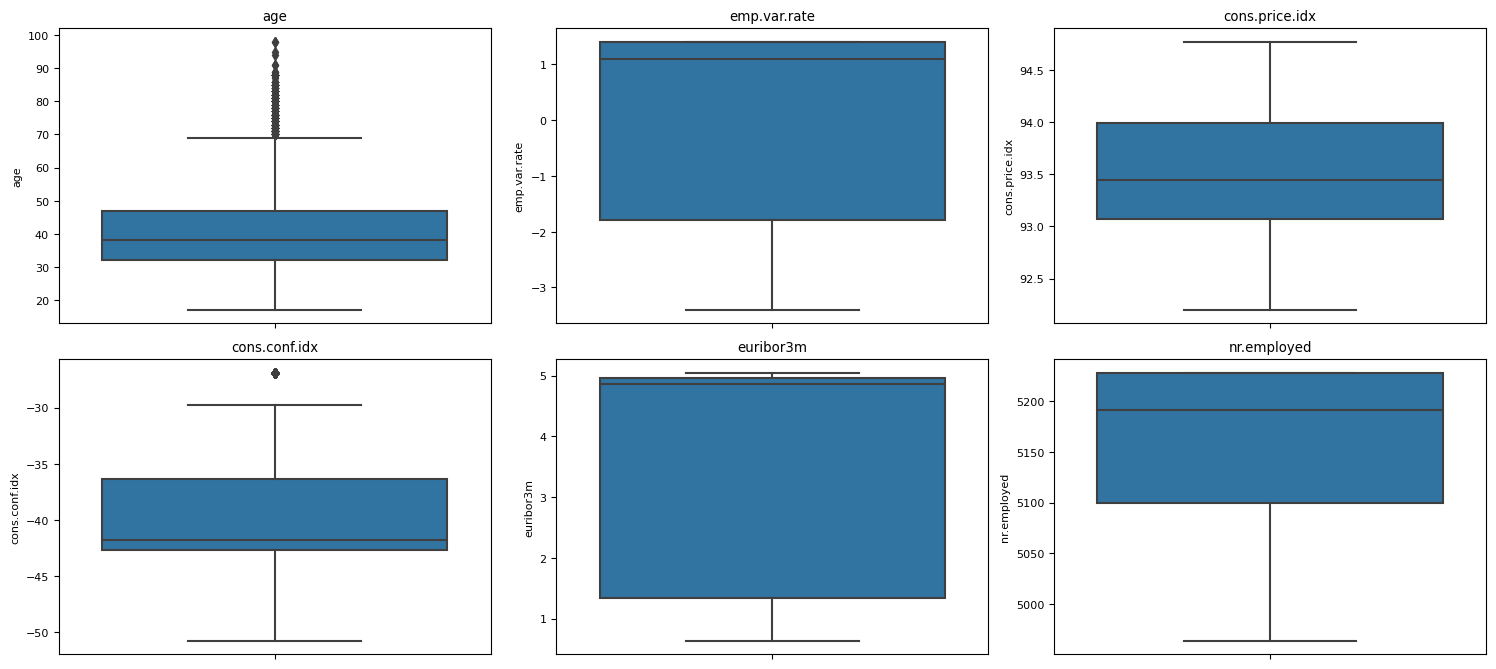

In [75]:
# create a figure with barplot subplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    sns.boxplot(y=df_demo[feature], showfliers=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


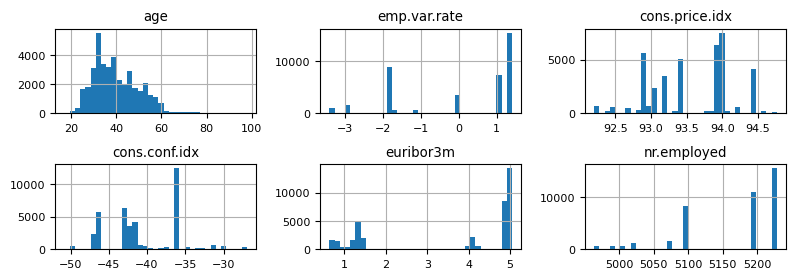

In [76]:
# create a figure with histogram subplots
plt.figure(figsize=(8, 4))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    df_demo[feature].hist(bins=35)
    plt.title(feature)
plt.tight_layout()
plt.show()


*[TODO] CONCLUSIE SCHRIJVEN OVER HISTOGRAMS*

## Feature engineering - iris

*[TODO] SCHRIJF INTRODUCTIE FEATURE ENGINEERING*

### Normalize numerical columns

*[TODO] NORMALIZATIE NIET GEBRUIKT KEUZE ONDERBOUWEN*

### All feature encoding of categorical features

*[TODO] INTRODUCEER EN ONDERBOUW LABEL ENCODING*

In [77]:
from sklearn.preprocessing import LabelEncoder

df_demo_encoded = df_demo #Copy dataset for encoding

# Apply label encoding to categorical columns
label_mappings = {}

for column in categorical_columns:
    le = LabelEncoder()
    ids = le.fit_transform(df_demo_encoded[column])
    df_demo_encoded[column] = ids
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    label_mappings.update(mapping)

#Encode the target variable
df_demo_encoded['y'] = df_demo_encoded['y'].map({'yes': 1, 'no': 0})
print(label_mappings)

{'admin.': 0, 'blue-collar': 1, 'entrepreneur': 2, 'housemaid': 3, 'management': 4, 'retired': 5, 'self-employed': 6, 'services': 7, 'student': 8, 'technician': 9, 'unemployed': 10, 'divorced': 0, 'married': 1, 'single': 2, 'basic.4y': 0, 'basic.6y': 1, 'basic.9y': 2, 'high.school': 3, 'illiterate': 4, 'professional.course': 5, 'university.degree': 6}


C:\Users\kyrii\AppData\Local\Temp\ipykernel_18392\3881851478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded[column] = ids
C:\Users\kyrii\AppData\Local\Temp\ipykernel_18392\3881851478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded[column] = ids
C:\Users\kyrii\AppData\Local\Temp\ipykernel_18392\3881851478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

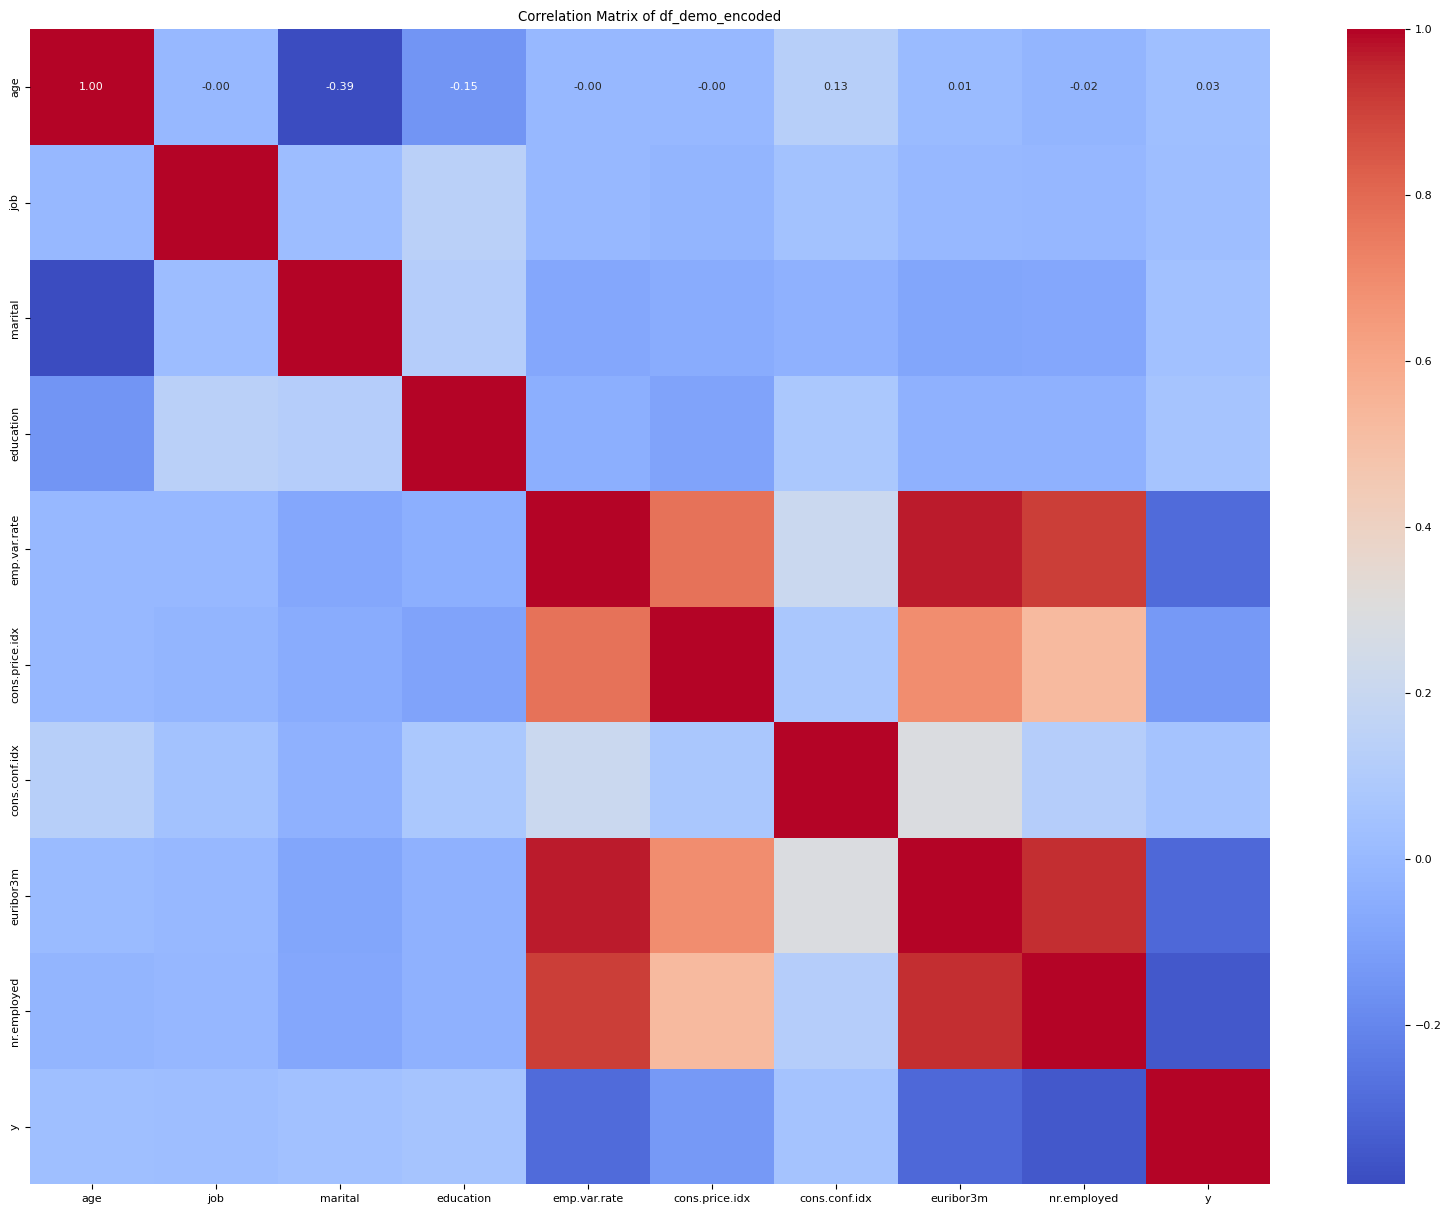

In [78]:
# Calculate the correlation matrix
correlation_matrix = df_demo_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of df_demo_encoded')
plt.show()

*[TODO] Uitleg en conclusie schrijven over correlation matrix*

In [79]:
# Calculate the correlation matrix for the target variable 'y' and other features
y_corr = df_demo_encoded.corr()[['y']]

print(y_corr)

                       y
age             0.030557
job             0.020840
marital         0.041972
education       0.054412
emp.var.rate   -0.293264
cons.price.idx -0.133833
cons.conf.idx   0.051365
euribor3m      -0.302094
nr.employed    -0.349526
y               1.000000


*[TODO] ONDERBOUW KEUZE OM TE FILTEREN OP HOGE CORRELATIE (ALS RELEVANT)*

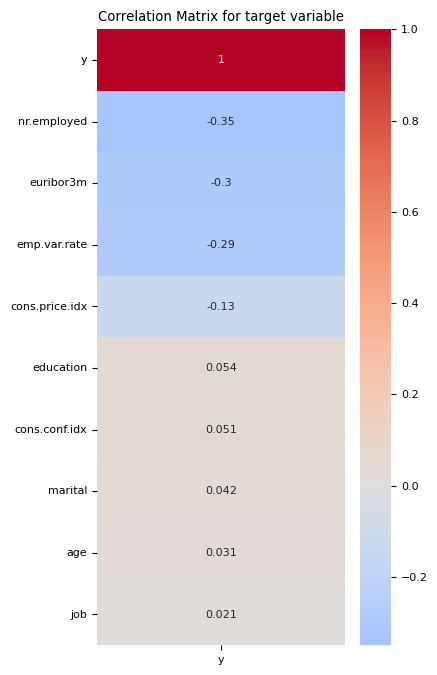

In [80]:
# Filter the correlation matrix for y_no and y_yes where the absolute value of correlation is higher than 0.1
#filtered_corr_matrix = y_corr[(y_corr['y_yes'].abs() > 0.1)]
filtered_corr_matrix = y_corr

#Sort the values by the absolute value of correlation for visualization purposes
filtered_corr_matrix = filtered_corr_matrix.reindex(filtered_corr_matrix['y'].abs().sort_values(ascending=False).index)

# Plot the heatmap for the filtered correlation matrix
plt.figure(figsize=(4, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for target variable')
plt.show()

*[TODO] CONCLUSIE SCHRIJVEN OVER CORRELATION MATRIX*

In [81]:
# Create pair plots
# sns.pairplot(df_demo_encoded[key_features])
# plt.show()

Ik denk dat deze pair plot overbodig is, geeft ons vgm niet veel extra informatie
- Onno

### Sampling considerations
There are way more y_no than y_yes. We have decided NOT to resample this, and instead use the imbalanced dataset. We will evaluate the models based on the AUC, which is a better metric for imbalanced datasets. This will also be explained later in the notebook.

In [82]:
# Separate majority and minority classes
df_majority = df_demo_encoded[df_demo_encoded['y'] == 0]
df_minority = df_demo_encoded[df_demo_encoded['y'] == 1]
print("Succesfull calls (Subscriptions to term deposit, y=1):", df_minority.shape[0])
print("Unsuccesfull calls (no subscription, y=0):", df_majority.shape[0])

Succesfull calls (Subscriptions to term deposit, y=1): 4360
Unsuccesfull calls (no subscription, y=0): 34831


## Clustering

In this section, we will be applying two clustering algorithms to the data: DBSCAN and Fuzzy C-Means Clustering. We chose to use DBSCAN because we saw from the EDA that we have a lot of outliers in our attributes. The decision for Fuzzy C-Means Clustering was made as we expect high overlap between the clusters, which this clustering method works well for.

In [ ]:
df_demo_encoded_no_y = df_demo_encoded.drop(columns=['y'])
df_demo_encoded_no_y.head()

### Cluster algorithm 1 - DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
 
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_demo_encoded_no_y)
distances, indices = neighbors_fit.kneighbors(df_demo_encoded_no_y)
distances = np.sort(distances, axis=0)[:,1]


In [ ]:
plt.xlim(30000, 39300)
plt.axhline(y=3, color='r', linestyle='--')
plt.plot(distances)

In [ ]:

#------------- AURELIA NOG AANPASSEN OM NIET HARDCODED TE ZIJN -----------------
# # Define a range of eps and min_samples values to test
# eps_values = np.arange(5, 10, 0.2)  # Adjust the range and step as necessary
# min_samples_values = range(9, 19)

# # Dictionary to store the results
# best_score = -1
# best_params = {}

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         # Apply DBSCAN
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(df_demo_encoded_no_y)
        
#         # Only compute silhouette score if there is more than 1 cluster
#         if len(set(labels)) > 1:
#             score = silhouette_score(df_demo_encoded_no_y, labels)
#             print(f"eps: {eps}, min_samples: {min_samples}, silhouette score: {score}")
            
#             # Check if this is the best score
#             if score > best_score:
#                 best_score = score
#                 best_params = {'eps': eps, 'min_samples': min_samples}

# print(f"Best params: {best_params}, Best silhouette score: {best_score}")

In [ ]:
# Run DBSCAN clustering
dbscan = DBSCAN(eps=8.2, min_samples=9)  # Values based on previous cell
df_demo_encoded['dbscan_cluster'] = dbscan.fit_predict(df_demo_encoded_no_y)

In [ ]:
sum(df_demo_encoded['dbscan_cluster'].unique())

In [ ]:
df_demo_encoded.columns

In [ ]:
# Plot the pairplot with hue based on the 'y' labels
sns.pairplot(df_demo_encoded, vars=df_demo_encoded.columns, 
             hue='y')  # 1 is yes, 0 is no
plt.suptitle("Pairplot Colored by 'y' Labels", y=1.02)
plt.show()

In [ ]:
# Plot the pairplot with hue based on the DBSCAN clusters
sns.pairplot(df_demo_encoded, vars=df_demo_encoded_no_y.columns, 
             hue='dbscan_cluster', palette='tab10')
plt.suptitle("Pairplot Colored by DBSCAN Clusters", y=1.02)
plt.show()

### Cluster algorithm 2  - Fuzzy C-Means Clustering

In [ ]:
# Redefining the cluster_range and accuracies for plotting process
cluster_range = range(1,11)
accuracies = []
all_clusters = []
data = df_demo_encoded_no_y

# Perform Fuzzy C-Means clustering for each number of clusters
for n_clusters in cluster_range:
    # Perform fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters, 2, error=0.005, maxiter=1000)
    
    # Assign clusters based on the highest membership
    clusters = np.argmax(u, axis=0)
    all_clusters.append(clusters)

print(all_clusters)

In [ ]:
from sklearn.metrics import confusion_matrix

true_labels = df_demo_encoded['y']

# Calculate accuracies for each clustering result
for clusters in all_clusters:
    # Using sklearn's confusion_matrix to generate the contingency matrix
    contingency_matrix = confusion_matrix(true_labels, clusters)
    
    # For each cluster, find the maximum true label count
    correct_predictions = sum(np.max(contingency_matrix, axis=0))

    # Calculate accuracy
    accuracy = correct_predictions / len(true_labels)
    accuracies.append(accuracy)


# Perform fuzzy c-means clustering with 4 clusters
n_clusters_4 = 4
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters_4, 2, error=0.005, maxiter=1000)
clusters4 = np.argmax(u, axis=0)

# Add the cluster assignment to the dataframe
df_demo_encoded['fuzzy_cluster'] = clusters4

# Plotting number of clusters vs. accuracy
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, accuracies, marker='o', color='b', label="Accuracy")
plt.title("Number of Clusters vs. Accuracy")
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy")
plt.xlim(0, 11)  # Setting x-axis limit
plt.ylim(0, 1.1)  # Setting y-axis limit
plt.xticks(range(0, 12))  # Setting x-ticks every 1 increment
plt.yticks(np.arange(0, 1.1, 0.1))  # Setting y-ticks every 0.1 increment
plt.grid()
plt.legend()

# Plot the clusters using pairplot
sns.pairplot(df_demo_encoded, vars=df_demo_encoded_no_y.columns, hue='fuzzy_cluster', palette='viridis')
plt.show()

# Print final clustering accuracy
print("Clustering Accuracies:", accuracies)

In [ ]:
# return cluster centers cntr 
print(f"Clusters centers: {cntr}")
# return membership matrix u
print(f"Memership matrix: {u}")

## Association rules

In [ ]:
df_ass_rules = df_demo_encoded
df_ass_rules = df_ass_rules.drop(['duration', 'pdays'], axis=1)
df_ass_rules

Implementation of Apriori

In [ ]:
df_ass_rules

In [ ]:
#I don't know why, but although this results in the exact same df it won't run without it
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res
    
basket_input = df_ass_rules.applymap(encode)

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Write your code for Association rules with 10% support and 20% confidence
frequent_items = apriori(basket_input, min_support=0.1, use_colnames=True)
frequent_items

In [ ]:
# with 20% Confidence
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.20)
rules

In [ ]:
# Order the most frequent item combinations in the entire dataset, by sorting the dataset by support, confidence, and lift
rules_sorted = rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False)
rules_sorted

We find that all the rules have a positive lift, meaning that they're good influential rules. The rules are sorted based importance.

The antecedents explain the consequents, as we are interested in explaining the y_yes variable, which indicates whether someone has received a loan or not, we will only be looking at those.

In [ ]:
# Done manually because of frozenset
rules_sorted = rules_sorted.drop([5, 0, 1, 3, 7, 8, 11])
rules_sorted

We find that that:"
1. given someone has cellular contact, there's a 39.55% chance they receive a loan.
2. Given someoen has previously received a loan, there's a 17.26% chance they receive a loan.
3. Given that they both have cellular contact, and received a loan previously, there's a 15.49% chance they receive a loan.
4. 5. TODO: debate whether these are necessary.

Visalising the confidence

In [ ]:
rules

In [ ]:
# Create a bar plot for confidence values
plt.figure(figsize=(10, 6))
sns.barplot(x='confidence', y='antecedents',  data=rules)

# Add title and labels
plt.title('Confidence of Association Rules', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)
plt.legend(title='Consequents', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
#### Visualization of obtained rules
plt.figure(figsize=(15,6))
sns.barplot(x="support",y="confidence",data=rules, palette='viridis')
plt.title("support vs confidence")
plt.show()

plt.figure(figsize=(15,6))
plt.scatter(rules['support'],rules['confidence'])
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

# Predictive Modelling


Now that we have performed EDA, feature engineering, clustering and association rule mining, we will move on to the predictive modelling part of the assignment. We will be using the following models:
- Support Vector Machine (SVM)
- eXtreme Gradient Boosting (XGBoost)
- Random Forest

These models were chosen because they are known to perform well on imbalanced datasets, which we have. We will be using the AUC as our evaluation metric, as it is a better metric for imbalanced datasets than accuracy. After evaluating all models the best performing will be chosen and finetuned for optimal performance.

First, we split the data into train and test data. We will use 80% of the data for training and 20% for testing. We will then train the models on the training data and evaluate them on the test data.

In [83]:
# Split data into train and test data
from sklearn.model_selection import train_test_split

X = df_demo_encoded.drop(['y'], axis=1)
y = df_demo_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

### Support Vector Machines (SVM)

Decision boundaries close to training points may generalize badly, since very similar (nearby) test points are classified as the other class.

Support Vector Machines (SVMs) try to solve these problems by employing a couple tricks:
- Choose a **boundary** that is as far away from training points as possible
- The **support vectors** are the training samples closest to the hyperplane
- The **margin** is the distance between the separating hyperplane and the _support vectors_

Hence, our objective with SVMs is to _maximize the margin_.

In [84]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Import SVC classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Import PCA
from sklearn.decomposition import PCA

In [85]:
# Plotting helpers. Based loosely on https://github.com/amueller/mglearn
def plot_svm_kernel(X, y, title, support_vectors, decision_function, dual_coef=None, show=True):
    """
    Visualizes the SVM model given the various outputs. It plots:
    * All the data point, color coded by class: blue or red
    * The support vectors, indicated by circling the points with a black border.
      If the dual coefficients are known (only for kernel SVMs) if paints support vectors with high coefficients darker
    * The decision function as a blue-to-red gradient. It is white where the decision function is near 0.
    * The decision boundary as a full line, and the SVM margins (-1 and +1 values) as a dashed line

    Attributes:
    X -- The training data
    y -- The correct labels
    title -- The plot title
    support_vectors -- the list of the coordinates of the support vectores
    decision_function - The decision function returned by the SVM
    dual_coef -- The dual coefficients of all the support vectors (not relevant for LinearSVM)
    show -- whether to plot the figure already or not
    """
    # plot the line, the points, and the nearest vectors to the plane
    #plt.figure(fignum, figsize=(5, 5))
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    if dual_coef is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c=dual_coef[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    else:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    plt.axis('tight')
    x_min, x_max = -3.5, 3.5
    y_min, y_max = -3.5, 3.5

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())

    if show:
        plt.show()

SVM can only be applied to continuous numerical data. As such, we will use one-hot encoding for the categorical variables: 'marital', 'job', and 'education'.

In [ ]:
# Create a copy of X_train specifically for SVM processing, as we will be modifying it. This ensures that the later models will not affected by the modifications.
X_train_svm = X_train.copy()
X_test_svm = X_test.copy()

In [89]:
# Apply one-hot encoding to the copied dataframes
X_train_svm = pd.get_dummies(X_train_svm, columns=['job', 'marital', 'education'])
X_test_svm = pd.get_dummies(X_test_svm, columns=['job', 'marital', 'education'])

# Align the columns in X_train_svm and X_test_svm to ensure they have the same features after encoding
X_train_svm, X_test_svm = X_train_svm.align(X_test_svm, join='left', axis=1, fill_value=0)

Secondly, due to the distinct natures of categorical and numerical data, we need to standardize the numerical variables in the dataset. This is because the SVM algorithm is sensitive to the scale of the input data. We will use the StandardScaler class from the sklearn.preprocessing module to standardize the numerical features in the dataset.

In [90]:
# Identify numerical columns
numerical_cols = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Initialize the scaler
scaler = StandardScaler()

# Scale numerical columns in the training set and apply the same transformation to the test set
X_train_svm[numerical_cols] = scaler.fit_transform(X_train_svm[numerical_cols])
X_test_svm[numerical_cols] = scaler.transform(X_test_svm[numerical_cols])

In [91]:
X_train_svm.head()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_0,job_1,job_2,job_3,...,marital_0,marital_1,marital_2,education_0,education_1,education_2,education_3,education_4,education_5,education_6
39918,0.013842,-1.138493,0.837988,0.156649,-1.669518,-2.451908,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False
8411,-0.864040,0.838839,1.549162,-0.276138,0.715270,0.844567,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
26486,-0.181243,-0.117935,-0.645069,-0.319417,0.259703,0.394351,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
28488,-1.351752,-1.202278,-0.861891,-1.423024,-1.274077,-0.953510,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
14132,-0.668955,0.838839,0.600352,-0.470892,0.771926,0.844567,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True


In [92]:
X_train_svm.shape

(31352, 27)

In [94]:
# Then, for visualization purpose, we will reduce the dimensionality of the data to 2 dimensions using PCA
pca = PCA(n_components=2)
X_train_svm_reduced = pca.fit_transform(X_train_svm)
X_test_svm_reduced = pca.fit_transform(X_test_svm)

In [96]:
X_test_svm_reduced.shape

(7839, 2)

Now that we have a reduced dataset, we can apply the grid search to find the best hyperparameters for the SVM model. We will use the GridSearchCV class from the sklearn.model_selection module to perform the grid search. We will use a 3-fold cross-validation to evaluate the performance of the model with different hyperparameters. We also need to include the class_weight='balanced' parameter to account for the imbalanced nature of the dataset.

In [28]:
# Instantiate parameters and models
param_svc = {'kernel':['linear', 'poly', 'rbf'], 'C':[0.001, 0.10, 1, 10], 'class_weight': ['balanced', None]}
params = [param_svc]
models = [SVC()]

In [29]:
xvals = [GridSearchCV(m, param, return_train_score = True, n_jobs = -1, verbose= True, cv=3, scoring = 'roc_auc').fit(X_train_svm_reduced, y_train) for m, param in zip(models, params)]

Fitting 3 folds for each of 24 candidates, totalling 72 fits


Then, we can print the table from the GridSearch

In [144]:
results_df = pd.DataFrame(xvals[0].cv_results_)
results_df = results_df.sort_values('rank_test_score').reset_index()
results_df = results_df.drop(['index'], axis=1)

In [145]:
results_df.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,120.228652,2.652029,27.731434,0.240909,10,balanced,rbf,"{'C': 10, 'class_weight': 'balanced', 'kernel'...",0.730140,0.726086,0.749596,0.735274,0.010262,1,0.740262,0.738469,0.731998,0.736910,0.003549
1,70.682355,1.136871,35.014299,0.644331,1,balanced,rbf,"{'C': 1, 'class_weight': 'balanced', 'kernel':...",0.720674,0.712841,0.740884,0.724800,0.011814,2,0.726761,0.732315,0.723299,0.727458,0.003714
2,49.545138,0.206872,11.885817,0.323992,0.001,balanced,poly,"{'C': 0.001, 'class_weight': 'balanced', 'kern...",0.721547,0.709885,0.736457,0.722630,0.010875,3,0.722665,0.728972,0.716357,0.722665,0.005150


As we can see in the table, the inclusion of the balanced parameter improves the performance of the model.

In [147]:
# Filter the results for balanced models
balanced_results = results_df[results_df['param_class_weight'] == 'balanced']

# Display the top 3 results for balanced models
print("Top 3 Balanced Model Results:")
balanced_results[['params', 'param_kernel', 'mean_test_score', 'mean_train_score']].head(3)

Top 3 Balanced Model Results:


,params,param_kernel,mean_test_score,mean_train_score
0,"{'C': 10, 'class_weight': 'balanced', 'kernel'...",rbf,0.735274,0.736910
1,"{'C': 1, 'class_weight': 'balanced', 'kernel':...",rbf,0.724800,0.727458
2,"{'C': 0.001, 'class_weight': 'balanced', 'kern...",poly,0.722630,0.722665


In [148]:
# Filter the results for unbalanced models
unbalanced_results = results_df[results_df['param_class_weight'].isnull()]

# Display the top 3 results for unbalanced models
print("Top 3 Unbalanced Model Results:")
unbalanced_results[['params', 'param_kernel', 'mean_test_score', 'mean_train_score']].head(3)


Top 3 Unbalanced Model Results:


,params,param_kernel,mean_test_score,mean_train_score
6,"{'C': 10, 'class_weight': None, 'kernel': 'lin...",linear,0.715508,0.711944
13,"{'C': 0.001, 'class_weight': None, 'kernel': '...",poly,0.695253,0.691729
14,"{'C': 10, 'class_weight': None, 'kernel': 'poly'}",poly,0.675843,0.669230


In [34]:
# Extract best parameters and print them
best_params = results_df['params'][0]
print(best_params)

{'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}


In [98]:
# Fit the model with the best parameters
best_svc = SVC(**best_params)
best_svc.fit(X_train_svm_reduced, y_train)

SVC(C=10, class_weight='balanced')

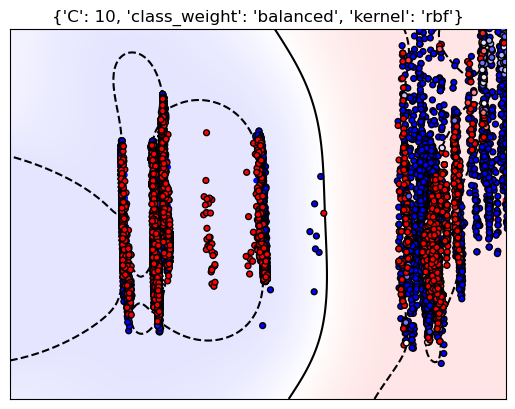

In [36]:
# For plotting, we'll use only 500 points
sample_size = 500

plot_svm_kernel(X_train_svm_reduced[:sample_size,], y_train[:sample_size,],best_params,
                best_svc.support_vectors_,
                best_svc.decision_function, best_svc.dual_coef_)

In this plot, we see the decision boundary of an SVM model with an RBF kernel, trained to predict whether individuals will subscribe to a term deposit based on several demographic and economic factors. Here are the key takeaways:

The RBF kernel allows the model to capture non-linear relationships among the factors influencing a subscription decision. This complexity indicates that the demographical and economic indicators interact in non-linear ways to affect the likelihood of subscription. However, since we have a relatively high C-value from the pre-defined parameters, this model might be prone to overfitting as when we would have chosen a lower C-value.

Additionally, by setting `class_weight='balanced'`, the model accounts for class imbalance, giving more weight to the minority class (which is in this case the positive outcomes)

Furthermore, the right side of the plot shows clusters where red and blue points are intermixed, indicating difficulty in distinguishing between subscribers and non-subscribers in this region of feature space. This overlap might reflect real-world ambiguity: for certain demographic or economic profiles, individuals could be equally likely to subscribe or not, meaning these features alone may not fully explain the decision to subscribe.

Lastly, the large number of support vectors (circled points) suggests that many data points are close to the decision boundary, indicating that the subscription decision is not clear-cut for most individuals. This aligns with the idea that small changes in someone's profile—such as slight variations in income or employment status—could impact their likelihood of subscribing.

### XGBoost (Onno)

**XGBoost (Extreme Gradient Boosting)** is a powerful and efficient machine learning algorithm based on the gradient boosting framework. It builds a strong model by combining many weak learners, in our case decision trees, in an iterative way to minimize prediction errors. With each iteration, XGBoost focuses on improving the accuracy by adjusting for errors made in previous rounds, which leads to high performance and accuracy.

First, the optimal hyperparameters (optimizing for AUC) will be determined using Grid search Cross Validation. Then an XGBoost model will be trained on these parameters. Finally, in the evaluation section, the model will be evaluated on the test set and compared to the other two models in this notebook.

In [39]:
#Import necessary libraries for XGBoost
from xgboost import XGBClassifier

#Import Gridsearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

#Initialize the XGBClassifier
xgb = XGBClassifier()

#Initialize the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
}

#Perform grid search with 5-fold cross-validation (~30 seconds)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

#Print the best parameters
print(grid_search.best_params_)

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


After finding the best possible parameters for the XGBoost model, we will train it on the training set.

In [40]:
#Initialize the XGBClassifier with the best parameters
xgb_best = XGBClassifier(**grid_search.best_params_)
xgb_best.fit(X_train, y_train);

In [41]:
len(xgb_best.feature_importances_)

9

KeyError: "['y'] not found in axis"

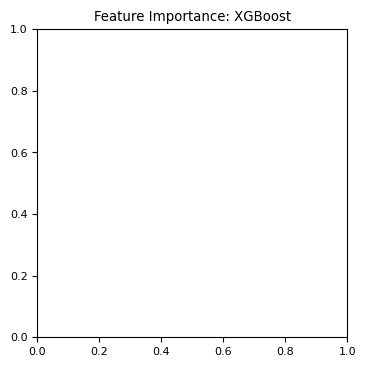

In [ ]:
#visualize feature importance
plt.figure(figsize=(4, 4));
plt.title('Feature Importance: XGBoost');
sns.barplot(x=xgb_best.feature_importances_, y=df_demo_encoded.drop('y'));
plt.xlabel('Feature Importance');
plt.ylabel('Feature');
plt.show()

*[TODO] CONCLUSIE OVER FEATURE IMPORTANCES*

### Random Forest (Mila)

**Decision Trees**, the building blocks of **Random Forests**, make decisions based on conditional splits at each node. These splits are determined by comparing feature values to a threshold and partitioning the data accordingly to minimize a cost function, often related to the impurity of the nodes (e.g., Gini impurity or entropy in classification problems). **Random Forests enhance the robustness of Decision Trees by creating an ensemble**. Each tree in the forest is trained on a random subset of the data (bootstrapped samples), and at each split, a random subset of features is considered. Compared to XGBoost, the Random Forest does not prune trees and can overfit if trees are fully grown. To avoid this, we wil first plot several different tree in terms of their dept. Besides that Random Forests struggle with imbalanced datasets (often biased towards majority class). In our case this is y=0. As our dataset is highly imbalanced, we will use the `stratify` parameter in the train test split function.

In order to assess the performance of the `RandomForestClassifier` across tress with varying depths, we will write a function `evaluate_RF`. The arguments of this function are given and are `X`, `y`, a list called `max_depths` and a variable called `scoring` along with an integer parameter `n_estimators`. For the `scoring` parameter, `balanced_accuracy` and `roc_auc_ovr_weighted` will be used as they deal with binary classification problems with imbalanced datasets.

From this plot we can estimate what our parameters in the `RandomForestClassifier` approximately will be, after which we will hyper tune it with `GridSearchCV`.

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from helper_functions import *
from IPython import display

RANDOM_SEED = 2

## Helper Functions for Live Model Plotting

def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 10))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

def plot_validation(X, y, evaluator):
    Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.8, random_state=RANDOM_SEED)

    plot_live(
        Xs,
        ys,
        evaluator,
        param_name='n_estimators',
        param_range=range(1, 32, 5),
        scale='linear'
    )

def evaluate_RF(X, y, n_estimators, max_depths, scoring):
    res = {}

    for md in max_depths:
        forest = RandomForestClassifier(n_estimators, max_depth=md, random_state=RANDOM_SEED)
        rf = cross_val_score(forest, X, y, cv=3, scoring=scoring)
        res['rf_' + str(md)] = sum(rf)/len(rf)

    return res

def evaluate_Roc_accuracy(X, y, n_estimators):
    return evaluate_RF(X, y, n_estimators, max_depths=[2, 8, 16, 24, 32, 64], scoring="roc_auc_ovr_weighted")

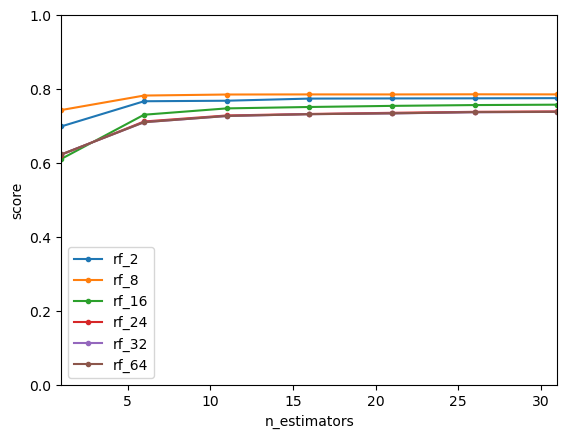

In [44]:
plot_validation(X, y, evaluate_Roc_accuracy)

From the plot, we evaluate the performance of a Random Forest model across different numbers of estimators (`n_estimators`, or the number of trees in the forest) and different maximum depths of trees. Here's what we can conclude from this analysis:

### Observations

1. **Score Stabilization with `n_estimators`**: It looks like the performance (score) stabilizes after a certain point in the number of estimators (around 10–15 estimators). Adding more trees beyond this point does not seem to significantly improve the score, suggesting that the model reaches its optimal performance with a relatively low number of trees.
   
2. **Impact of Maximum Depth**: The different lines in the plot represent various maximum depth values (rf_2, rf_8, rf_16, etc.). The maximum depth has a minor but visible impact on performance. Lower depth (e.g., `max_depth=2`) has slightly lower scores, while higher depths (e.g., `max_depth=16` or `max_depth=24`) have higher scores initially but don't show significant improvement at higher `n_estimators` values. This indicates that for this dataset, increasing depth improves performance only to a certain level before it plateaus.

3. **Diminishing Returns**: Both increasing `n_estimators` and `max_depth` beyond certain values yield diminishing returns. After a certain depth (possibly around 16) and number of estimators (around 15), the performance remains steady.


Based on the plot, a good grid search can focus on a smaller range of values rather than an extensive search, which would save computational time. We will test the following numbers for the parameters:

- **`n_estimators`**: Test values from 5 to 50, in increments like `[5, 10, 15, 20]`. Since the performance stabilizes after around 15 trees, we don't need to go much higher.
  
- **`max_depth`**: We will use values in the range of `[8, 16, 24, 32]`. The model shows slight improvements as depth increases, but beyond 24 or 32, it’s likely that the additional depth won’t add much value.

- **Other Parameters**: To further refine the model, you might also include:
  - **`min_samples_split`**: `[2, 5, 10]` (controls the minimum number of samples required to split an internal node).
  - **`min_samples_leaf`**: `[1, 2, 4]` (controls the minimum number of samples required to be at a leaf node).
  - **`max_features`**: Try a few options, such as `"sqrt"`, `"log2"`, or a fixed number (like half or one-third of the number of features), to control the number of features considered at each split.

First, the optimal hyperparameters (optimizing for `n_estimators`, `criterion` and `max_depth`) will be determined using Grid Search Cross Validation. Then an Random Forest model will be trained on these parameters. 

In [45]:
# Import necessary libraries for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_rf = {
    'n_estimators': np.linspace(5, 50, num=5, dtype=int),  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [5,10,15,20],  # Maximum depth of the tree
}

rf = RandomForestClassifier()
grid_searches = GridSearchCV(rf, param_rf, scoring = 'accuracy', cv=3, return_train_score=True, n_jobs = -1).fit(X,y)

sorted(grid_searches.cv_results_.keys())

cv_results = grid_searches.cv_results_

results_df = pd.DataFrame({
    'mean_fit_time': cv_results['mean_fit_time'],
    'mean_score_time': cv_results['mean_score_time'],
    'mean_test_score': cv_results['mean_test_score'],
    'mean_train_score': cv_results['mean_train_score'],
    'param_criterion': cv_results['param_criterion'],
    'param_n_estimators': cv_results['param_n_estimators'],
    'std_test_score': cv_results['std_test_score'],
    'std_train_score': cv_results['std_train_score'],
    'rank_test_score': cv_results['rank_test_score']
})

# Apply the highlighting
results_df = results_df.sort_values(by = 'rank_test_score')

results_df['param_n_estimators'] = pd.to_numeric(results_df['param_n_estimators'])

In [46]:
# Showing the top 5 best models
results_df_highlight = results_df.style.apply(highlight_best_worst, subset=['mean_test_score'])
results_df_highlight.data

print(f"Best parameters: {grid_searches.best_params_}")

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 16}


From the dataframe we can conclude that the bet parameters are: The `criterion` used is entropy, `max_depth` of the trees is 5 and the number of trees is 5. This shows that the model needs few trees to make a good prediction.
Let's fit the model and see what the important features are.

In [47]:
# Initialize the Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(**grid_searches.best_params_)
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
# Find the best model
rf_best.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=16)

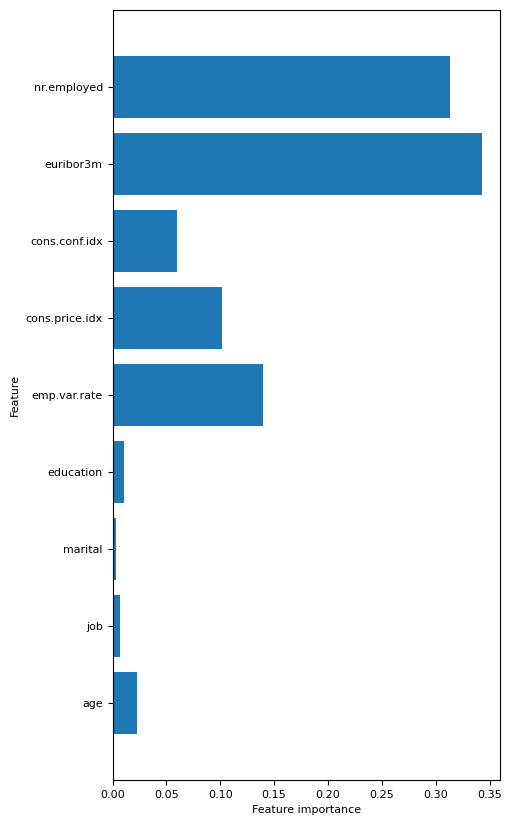

In [49]:
def plot_feature_importances(features, model):
    n_features = len(features)
    plt.figure(figsize=(5,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(range(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
df_plot = df_demo_encoded.drop(['y'], axis=1)
plt.rcParams.update({'font.size':8})
plot_feature_importances(df_plot.columns, rf_best)

After running the Random Forest with a GridSearch on the n_estimators and criterion, Let's have a look how the model performs compared to the other models in ROC-AUC, recall, precision etc.


# Comparison between the 3 models

In order to compare the performance of the three models, we will use the following metrics: accuracy, precision, recall, F1 score, and ROC AUC score. We will also plot the ROC curve for each model. In the end, the best model will be chosen based on the ROC AUC score as this most accurately represents the performance of the model.

In [129]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

SVM performance metrics:

In [130]:
#Predict the target variable
y_pred_svm = best_svc.predict(X_test_svm_reduced)

In [131]:
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

Accuracy:  0.7188416889909427
Precision:  0.24285714285714285
Recall:  0.7213302752293578
F1 Score:  0.3633737723859041
ROC AUC Score:  0.7199302445473615


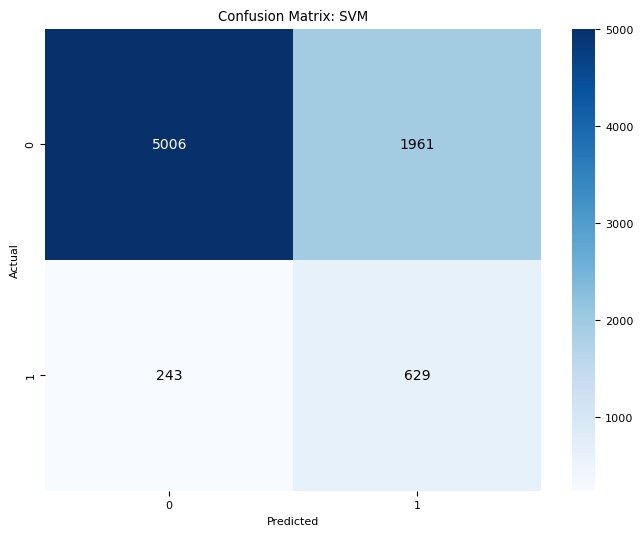

In [133]:
#Print evaluation measures
print('Accuracy: ', accuracy_score(y_test, y_pred_svm))
print('Precision: ', precision_score(y_test, y_pred_svm))
print('Recall: ', recall_score(y_test, y_pred_svm))
print('F1 Score: ', f1_score(y_test, y_pred_svm))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred_svm))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: SVM');

sns.heatmap(confusion_matrix_svm, fmt='d', cmap='Blues');

# Manually add annotations with appropriate text color based on cell intensity
for i in range(confusion_matrix_svm.shape[0]):
    for j in range(confusion_matrix_svm.shape[1]):
        color = "white" if confusion_matrix_svm[i, j] > confusion_matrix_svm.max() / 2 else "black"
        plt.text(j + 0.5, i + 0.5, confusion_matrix_svm[i, j],
                 ha="center", va="center", color=color, fontsize=10)
        
plt.xlabel('Predicted');
plt.ylabel('Actual');

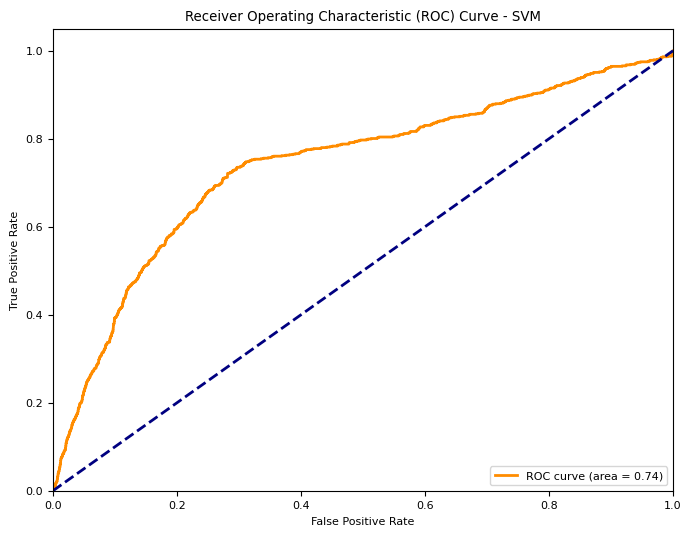

In [136]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_pred_prob_svm = best_svc.decision_function(X_test_svm_reduced)

# Compute ROC curve and ROC area
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc="lower right")
plt.show()

XGBoost performance metrics:

Accuracy:  0.8900369945146065
Precision:  0.5178571428571429
Recall:  0.16628440366972477
F1 Score:  0.2517361111111111
ROC AUC Score:  0.573453670185659


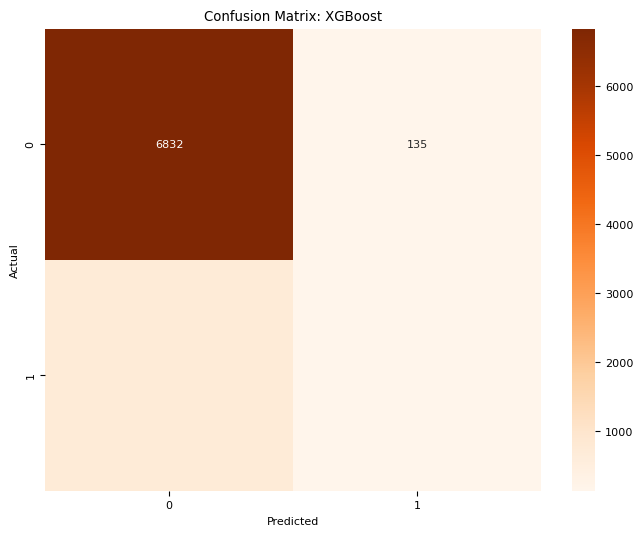

In [137]:
#Predict the target variable
y_pred_xgb = xgb_best.predict(X_test)

#Print evaluation measures
print('Accuracy: ', accuracy_score(y_test, y_pred_xgb))
print('Precision: ', precision_score(y_test, y_pred_xgb))
print('Recall: ', recall_score(y_test, y_pred_xgb))
print('F1 Score: ', f1_score(y_test, y_pred_xgb))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred_xgb))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: XGBoost');

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

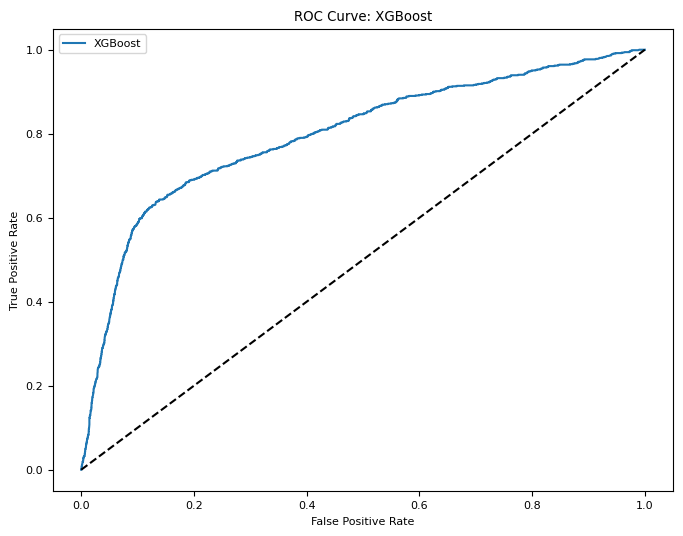

In [138]:
#Plot ROC curve
from sklearn.metrics import roc_curve

#Calculate the probabilities
y_pred_prob_xgb = xgb_best.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

#Plot the ROC curve
plt.figure(figsize=(8, 6));
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost');
plt.plot([0, 1], [0, 1], 'k--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve: XGBoost');
plt.legend();
plt.show()

Random Forest performance metrics:

Accuracy: 0.891822936599056
Precision: 0.5375
Recall: 0.19724770642201836
F1 Score: 0.28859060402684567
ROC AUC Score: 0.5880023518474381


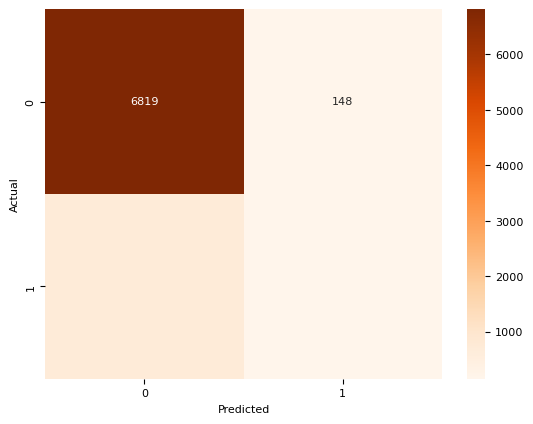

In [139]:
# Predict the target variable
y_pred_rf = rf_best.predict(X_test)

# Print evaluation measures
print('Accuracy:', np.mean(y_test == y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_rf))

# Visualize confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap=plt.cm.Oranges)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


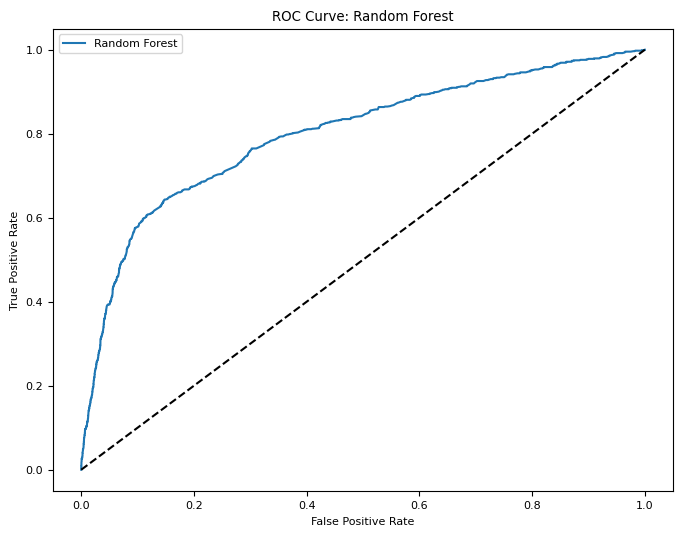

In [140]:
#Plot ROC curve
from sklearn.metrics import roc_curve

#Calculate the probabilities
y_pred_prob_rf = rf_best.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

#Plot the ROC curve
plt.figure(figsize=(8, 6));
plt.plot(fpr_rf, tpr_rf, label='Random Forest');
plt.plot([0, 1], [0, 1], 'k--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve: Random Forest');
plt.legend();
plt.show()

SVM ROC AUC Score: 0.7386776191297638
XGBoost ROC AUC Score: 0.796251134114561
Random Forest ROC AUC Score: 0.799041895409947


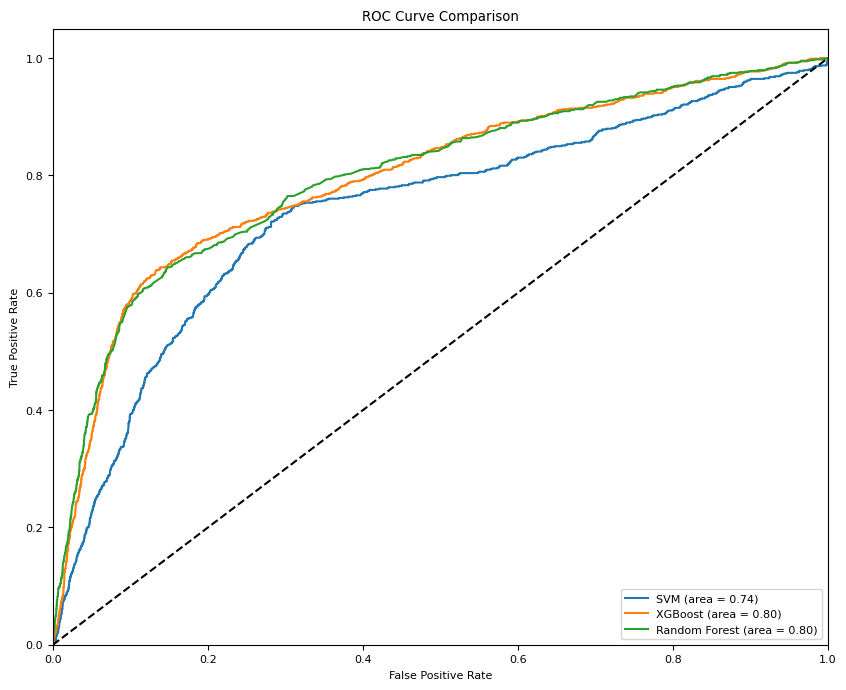

In [141]:
# Print ROC AUC scores for the three models
print(f"SVM ROC AUC Score: {roc_auc_svm}")
print(f"XGBoost ROC AUC Score: {roc_auc_xgb}")
print(f"Random Forest ROC AUC Score: {roc_auc_rf}")

# Plot ROC curves for comparison
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

In conclusion, when comparing performances of the three models, we observe that the Random Forest model performs the best in terms of ROC AUC score. Therefore, we will choose the Random Forest model as the best model for predicting whether a client will subscribe to a term deposit.

## Random Forest with Socio-Economic variables, and with Socio-Economic variables

The purpose of this analysis was to evaluate the effectiveness of using demographic and socio-economic data in predicting client subscription to term deposits, as posed in our research question:

*"To what extent does the inclusion of socio-economic variables improve the accuracy of predicting client subscription to term deposits when compared to only using demographic variables?"*

To address this question, we first aimed to identify the best predictive model using both demographic and socio-economic variables, without yet isolating their individual contributions. By training multiple models (XGBoost, SVM, and Random Forest) on all those variables and evaluating their performance on the ROC AUC curve, we ensured that we selected the most robust model for further analysis. We found that Random Forest had the highest performance when trained on all variables, so we continued assessing the added value of socio-economic data with that model.

With the Random Forest model chosen, we proceeded to analyze the impact of feature sets by comparing the model’s performance using only demographic variables versus using both demographic and socio-economic variables. This approach allowed us to control for model quality, ensuring that any observed differences in predictive accuracy were due to the feature sets themselves rather than model selection.

The following sections will delve deeper into the comparison of the ROC curve between models trained with demographic variables only and those enhanced with socio-economic variables.

### Only demographic variables

In [154]:
# Define only demographic variables
demographic_variables = ['age', 'job', 'marital', 'education', 'y'] 
df_demographic = df_demo_encoded[demographic_variables]

In [155]:
X_demographic = df_demographic.drop(['y'], axis=1)
y_demographic = df_demographic['y']

In [156]:
# Split the data into train and test sets
X_train_demographic, X_test_demographic, y_train_demographic, y_test_demographic = train_test_split(X_demographic, y_demographic, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [157]:
rf_demographic = RandomForestClassifier(**grid_searches.best_params_)
rf_demographic.fit(X_train_demographic, y_train_demographic)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=16)

In [158]:
# Predict and evaluate the model without socio-economic variables
y_pred_demographic = rf_demographic.predict(X_test_demographic)
print("\nPerformance without socio-economic variables:")
print('Accuracy:', accuracy_score(y_test, y_pred_demographic))
print('Precision:', precision_score(y_test, y_pred_demographic))
print('Recall:', recall_score(y_test, y_pred_demographic))
print('F1 Score:', f1_score(y_test, y_pred_demographic))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_demographic))


Performance without socio-economic variables:
Accuracy: 0.8887613215971425
Precision: 0.5
Recall: 0.014908256880733946
F1 Score: 0.028953229398663696
ROC AUC Score: 0.5065211587259992


### With socio-economic variables

In [166]:
# Train the Random Forest model with all variables
rf_all = RandomForestClassifier(**grid_searches.best_params_)
rf_all.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=16)

In [167]:
# Predict and evaluate the model with all variables
y_pred_all = rf_all.predict(X_test)
print("Performance with all variables:")
print('Accuracy:', accuracy_score(y_test, y_pred_all))
print('Precision:', precision_score(y_test, y_pred_all))
print('Recall:', recall_score(y_test, y_pred_all))
print('F1 Score:', f1_score(y_test, y_pred_all))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_all))

Performance with all variables:
Accuracy: 0.8904196963898456
Precision: 0.5281385281385281
Recall: 0.13990825688073394
F1 Score: 0.22121486854034453
ROC AUC Score: 0.562131536219899


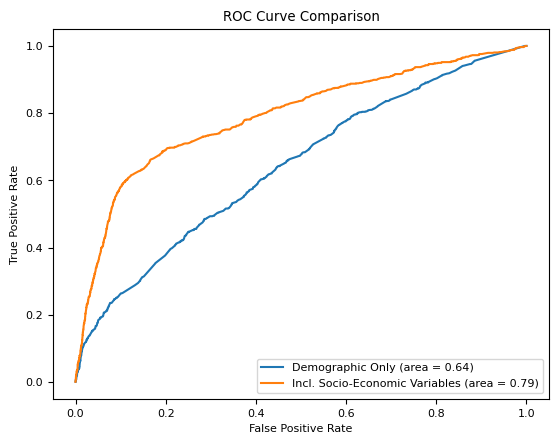

In [168]:
# Plot ROC curve for demographic variables only
y_pred_prob_demographic = rf_demographic.predict_proba(X_test_demographic)[:, 1]
fpr_demographic, tpr_demographic, _ = roc_curve(y_test, y_pred_prob_demographic)
roc_auc_demographic = auc(fpr_demographic, tpr_demographic)
plt.plot(fpr_demographic, tpr_demographic, label=f'Demographic Only (area = {roc_auc_demographic:.2f})')

# Plot ROC curve for all variables
y_pred_prob_all = rf_all.predict_proba(X_test)[:, 1]
fpr_all, tpr_all, _ = roc_curve(y_test, y_pred_prob_all)
roc_auc_all = auc(fpr_all, tpr_all)
plt.plot(fpr_all, tpr_all, label=f'Incl. Socio-Economic Variables (area = {roc_auc_all:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

### Final Interpretation and Conclusion

In this plot, we compare the ROC curves of two models predicting whether clients will subscribe to a term deposit: one using only demographic variables (in blue) and another that includes both demographic and socio-economic variables (in orange). The goal of this comparison is to assess the extent to which the inclusion of socio-economic variables improves predictive performance.

1. **ROC Curve Comparison**:
   - The ROC curve shows the trade-off between the true positive rate (sensitivity) and the false positive rate at various threshold levels. A higher area under the curve (AUC) indicates better discriminatory power of the model.
   - The blue curve represents the model trained only on demographic variables, achieving an AUC of 0.64. This indicates limited predictive power, as the model struggles to differentiate between clients likely and unlikely to subscribe based solely on demographic data.
   - The orange curve, representing the model trained on both demographic and socio-economic variables, achieves a significantly higher AUC of 0.79. This indicates a considerable improvement in the model’s ability to discriminate between the two classes when socio-economic variables are included.

2. **Impact of Including Socio-Economic Variables**:
   - The difference in AUC scores (0.79 vs. 0.64) demonstrates that socio-economic variables provide valuable information that improves the model’s accuracy in predicting client subscriptions. This suggests that factors like employment variation rate, consumer confidence index, and other economic indicators play a crucial role in clients’ decision-making processes.
   - The improvement in performance aligns with real-world intuition; economic conditions often influence financial decisions, making socio-economic context an important predictor for subscription to term deposits.

3. **Conclusion in Relation to Research Question**:
   - Based on our research question, "To what extent does the inclusion of socio-economic variables improve the accuracy of predicting client subscription to term deposits when compared to only using demographic variables?", this analysis provides a clear answer.
   - The inclusion of socio-economic variables substantially enhances the model’s predictive performance, as shown by the significant increase in AUC. This finding suggests that demographic data alone may be insufficient for accurately predicting client behavior in this context. Including socio-economic factors enables a more comprehensive understanding of clients' likelihood to subscribe, reflecting the broader influences on financial decision-making.

4. **Model Choice and Implications**:
   - Given that the Random Forest model performed best in our study, we conclude that it is a suitable choice for this classification task, particularly with the inclusion of socio-economic variables. This model’s ability to capture complex relationships in the data makes it well-suited for understanding client subscription behavior.
   - This result implies that financial institutions can improve the effectiveness of their marketing strategies by incorporating both demographic and socio-economic data, enabling more targeted and informed campaigns.

In summary, this analysis highlights the importance of including socio-economic factors alongside demographic data in predictive models for term deposit subscriptions. By doing so, we achieve greater accuracy and a better understanding of client behavior, which can inform more effective marketing strategies.
